In [ ]:
import os
import json
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

mlflow.set_experiment("iml2025_project")
EDA_RUN_NAME = "01_EDA"

os.makedirs("../logs/eda_plots", exist_ok=True)

2025/12/06 14:44:49 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/06 14:44:49 INFO mlflow.store.db.utils: Updating database tables
2025/12/06 14:44:49 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/06 14:44:49 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/06 14:44:49 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/06 14:44:49 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/06 14:44:49 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/06 14:44:49 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/06 14:44:49 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/06 14:44:49 INFO alembic.runtime.migration: Running 

In [4]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

train["class2"] = (train["class4"] != "nonevent").astype(int)
X = train.drop(["id","date","class2","class4"], axis=1)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (450, 105)
Test shape: (965, 103)


,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,...,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,class2
0,0,2000-03-21,II,False,372.396757,0.752494,372.279392,0.716926,372.876081,0.817532,...,2.041327,3.615784,2.283825,6.237543,4.372063,0.115203,0.104295,0.000510,0.000123,1
1,1,2000-03-23,nonevent,False,372.889867,0.410639,372.769205,0.380586,373.387815,0.478567,...,1.888414,-0.323360,1.979027,11.626868,7.208083,0.301720,0.229672,0.000706,0.000250,0
2,2,2000-04-07,Ia,False,373.869464,0.655604,373.788580,0.649312,374.356310,0.629567,...,1.610976,3.181058,1.929516,16.688892,10.504951,0.561251,0.451130,0.000851,0.000244,1
3,3,2000-04-09,Ib,False,376.006588,1.109789,375.888889,1.052157,376.779883,1.403241,...,2.831278,4.677937,3.161601,17.456796,10.967471,0.716453,0.572409,0.002083,0.000203,1
4,4,2000-04-14,nonevent,False,374.068239,1.257096,374.042330,1.214805,374.725480,1.374858,...,0.934736,2.009219,0.929537,4.279844,2.425409,0.146308,0.106017,0.002650,0.000891,0


# Summary & Missing Values

In [6]:
eda_stats = {
    "shape": str(train.shape),
    "missing_values": train.isna().sum().to_dict(),
    "dtypes": train.dtypes.astype(str).to_dict(),
    "class2_counts": train["class2"].value_counts().to_dict(),
    "class4_counts": train["class4"].value_counts().to_dict()
}

json.dump(eda_stats, open("../logs/metrics/eda_stats.json","w"), indent=4)
eda_stats


{'shape': '(450, 105)',
 'missing_values': {'id': 0,
  'date': 0,
  'class4': 0,
  'partlybad': 0,
  'CO2168.mean': 0,
  'CO2168.std': 0,
  'CO2336.mean': 0,
  'CO2336.std': 0,
  'CO242.mean': 0,
  'CO242.std': 0,
  'CO2504.mean': 0,
  'CO2504.std': 0,
  'Glob.mean': 0,
  'Glob.std': 0,
  'H2O168.mean': 0,
  'H2O168.std': 0,
  'H2O336.mean': 0,
  'H2O336.std': 0,
  'H2O42.mean': 0,
  'H2O42.std': 0,
  'H2O504.mean': 0,
  'H2O504.std': 0,
  'H2O672.mean': 0,
  'H2O672.std': 0,
  'H2O84.mean': 0,
  'H2O84.std': 0,
  'NET.mean': 0,
  'NET.std': 0,
  'NO168.mean': 0,
  'NO168.std': 0,
  'NO336.mean': 0,
  'NO336.std': 0,
  'NO42.mean': 0,
  'NO42.std': 0,
  'NO504.mean': 0,
  'NO504.std': 0,
  'NO672.mean': 0,
  'NO672.std': 0,
  'NO84.mean': 0,
  'NO84.std': 0,
  'NOx168.mean': 0,
  'NOx168.std': 0,
  'NOx336.mean': 0,
  'NOx336.std': 0,
  'NOx42.mean': 0,
  'NOx42.std': 0,
  'NOx504.mean': 0,
  'NOx504.std': 0,
  'NOx672.mean': 0,
  'NOx672.std': 0,
  'NOx84.mean': 0,
  'NOx84.std': 0,
 

# Distribution Plots

In [ ]:

for col in X.columns[:50]:   # first 50 to avoid 100+ figure spam
    plt.figure(figsize=(5,3))
    sns.histplot(train[col], kde=True)
    plt.title(f"Distribution of {col}")
    path = f"../logs/eda_plots/dist_{col}.png"
    plt.savefig(path, dpi=200, bbox_inches='tight')
    plt.close()


# Corelation & Cluster Maps

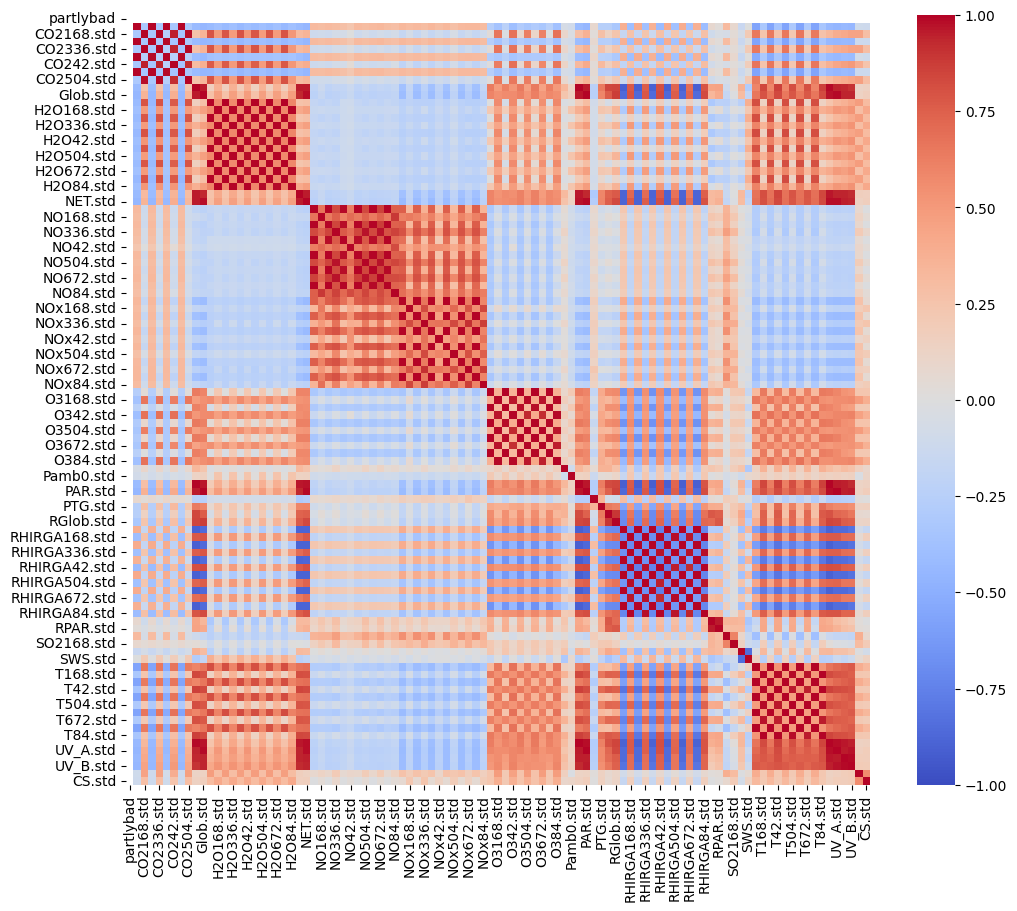

In [11]:
corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", vmax=1, vmin=-1)
path = "../logs/eda_plots/corr_heatmap.png"
plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()


# PCA - 2D Plot


Explained variance by first 2 components:
PC1: 0.3914
PC2: 0.1531
Total: 0.5445


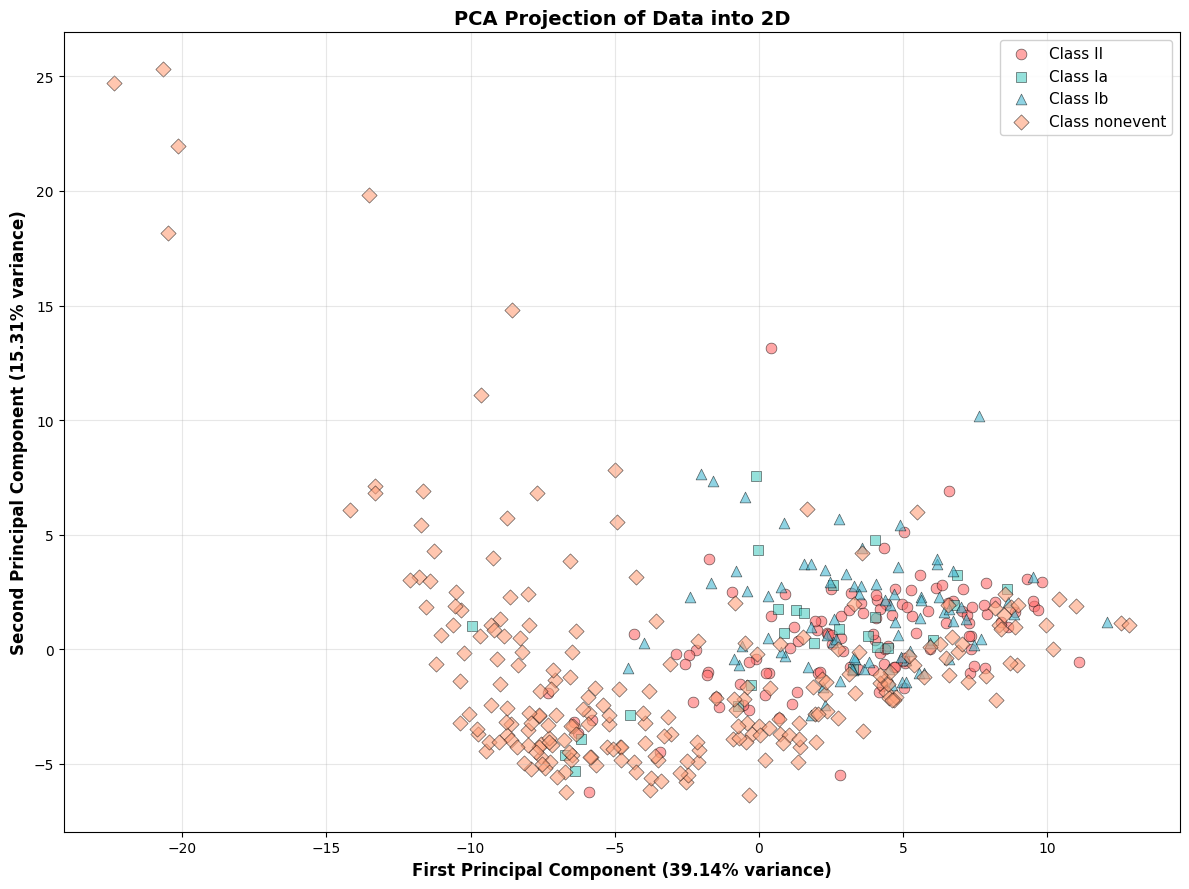

In [14]:
with mlflow.start_run(run_name=EDA_RUN_NAME+"_pca"):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y = train["class4"].values

    # Perform PCA to 2 dimensions
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_scaled)

    print(f"\nExplained variance by first 2 components:")
    print(f"PC1: {pca_2d.explained_variance_ratio_[0]:.4f}")
    print(f"PC2: {pca_2d.explained_variance_ratio_[1]:.4f}")
    print(f"Total: {pca_2d.explained_variance_ratio_.sum():.4f}")

    # Create visualization with different colors and markers for each class
    fig, ax = plt.subplots(figsize=(12, 9))

    # Define colors and markers for each class
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    markers = ['o', 's', '^', 'D']
    class_names = sorted(np.unique(y))

    # Plot each class with different color and marker
    for i, (cls, color, marker) in enumerate(zip(class_names, colors, markers)):
        mask = y == cls
        ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                    c=color, marker=marker, s=60, alpha=0.6, 
                    edgecolors='black', linewidths=0.5,
                    label=f'Class {cls}')

    ax.set_xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.2%} variance)', 
                fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.2%} variance)', 
                fontsize=12, fontweight='bold')
    ax.set_title('PCA Projection of Data into 2D', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    path = "../logs/eda_plots/pca_class4.png"
    plt.savefig(path, dpi=200, bbox_inches='tight')
    mlflow.log_artifact(path)
    # Log explained variance
    mlflow.log_metric("pca_var_comp1", pca_2d.explained_variance_ratio_[0])
    mlflow.log_metric("pca_var_comp2", pca_2d.explained_variance_ratio_[1])
    plt.show()

# KMeans Clustering

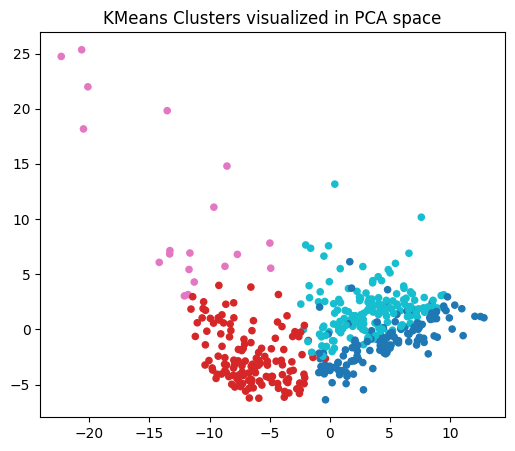

In [18]:
import sys
import os

# Add project root (folder containing src/)
sys.path.append(os.path.abspath(".."))
from src.utils import save_df

with mlflow.start_run(run_name=EDA_RUN_NAME+"_kmeans"):
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    plt.figure(figsize=(6,5))
    plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=clusters, cmap="tab10", s=20)
    plt.title("KMeans Clusters visualized in PCA space")
    path = "../logs/eda_plots/kmeans_pca.png"
    plt.savefig(path, dpi=200, bbox_inches='tight')
    mlflow.log_artifact(path)
    plt.show()

    df_cluster_summary = pd.DataFrame({"cluster":clusters, "class4":train["class4"]})
    mlflow.log_artifact(path)
    save_df(df_cluster_summary, "../logs/metrics/kmeans_cluster_summary.csv")
